<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Jupyter%20Notebook%20Scripts/Sampling_Budget_Analogy_for_Qubit_Classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling Budget & Bit-String Analogy for Qubit Classes/ Classifications

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

Running simulation...
Saved data to CSV and JSON files.


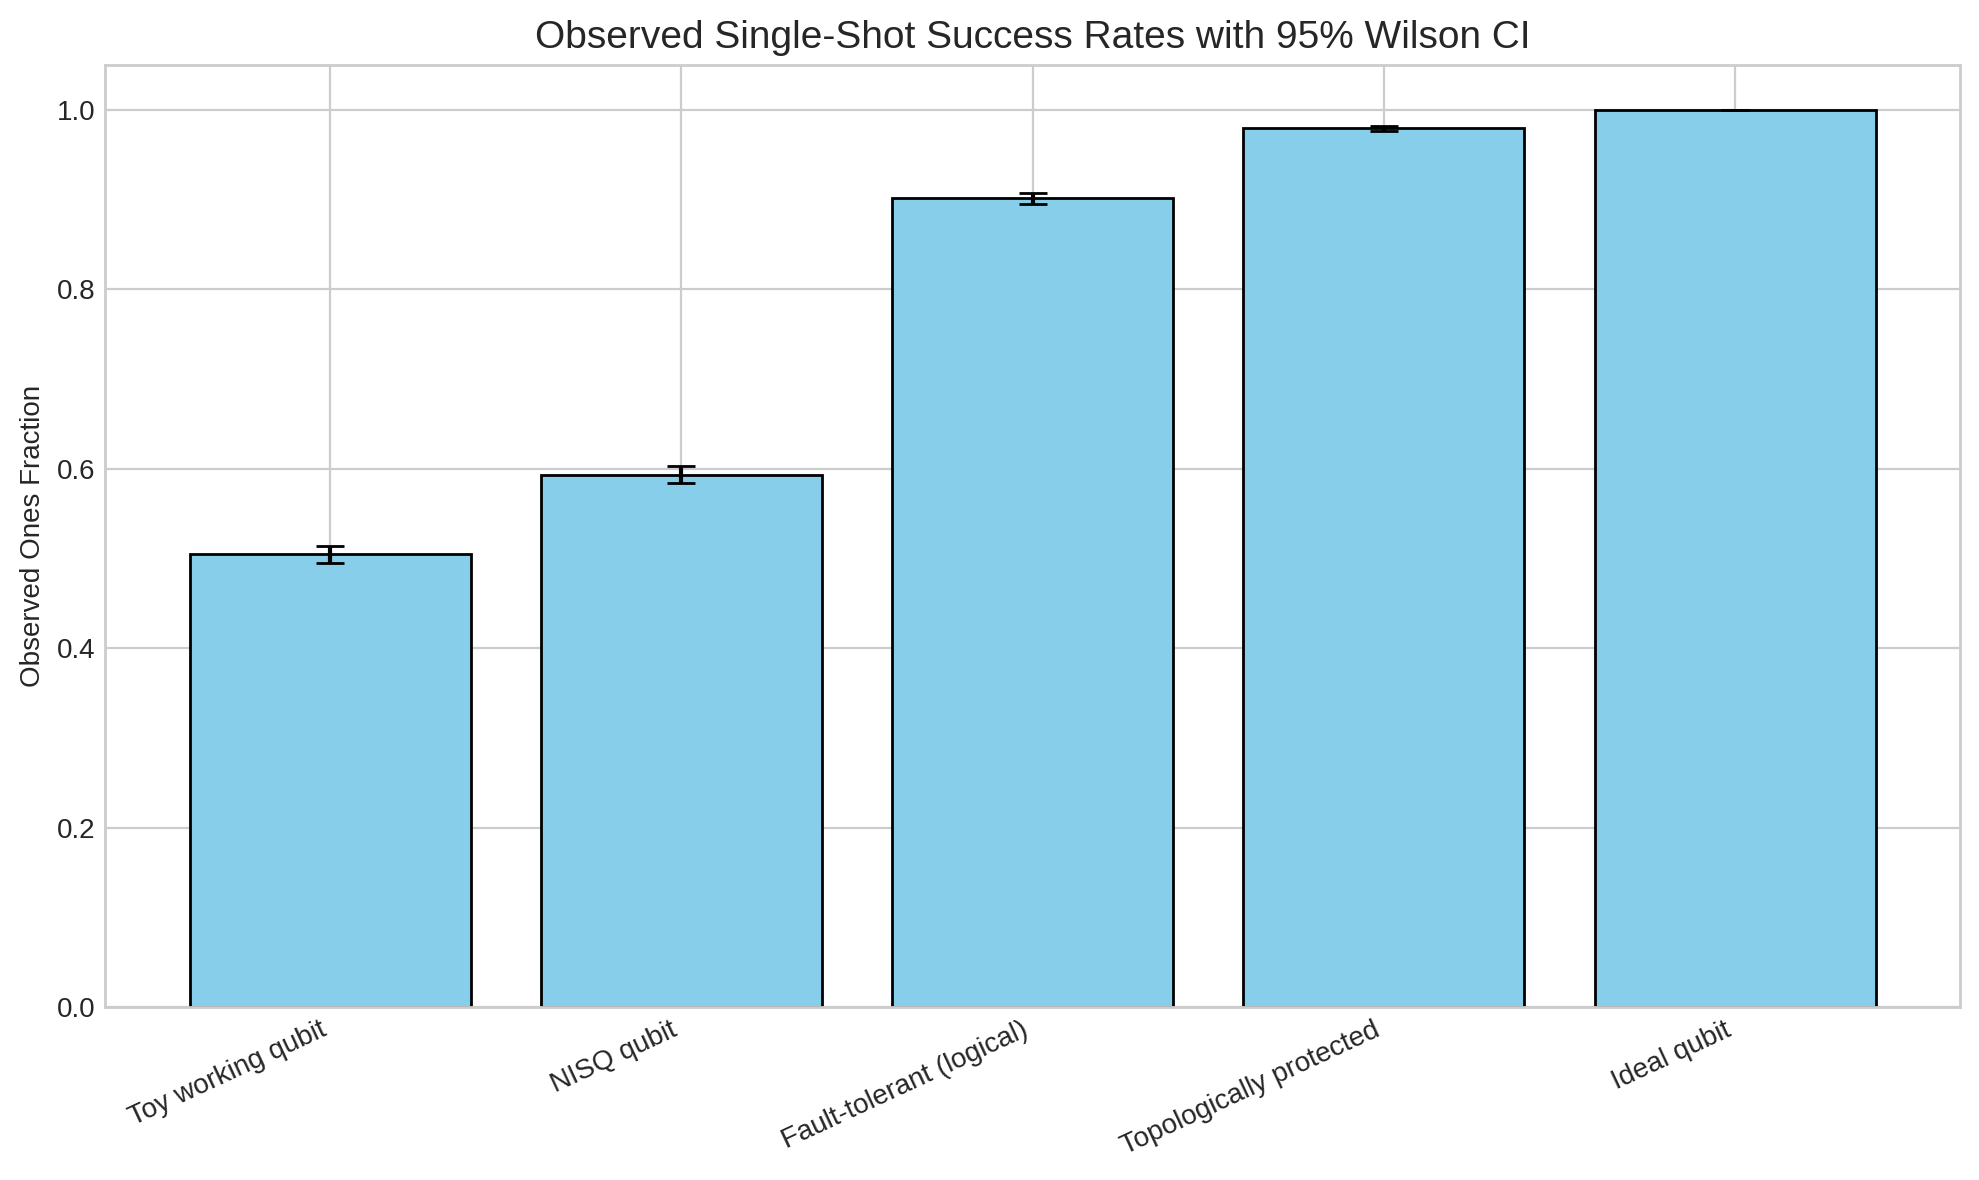

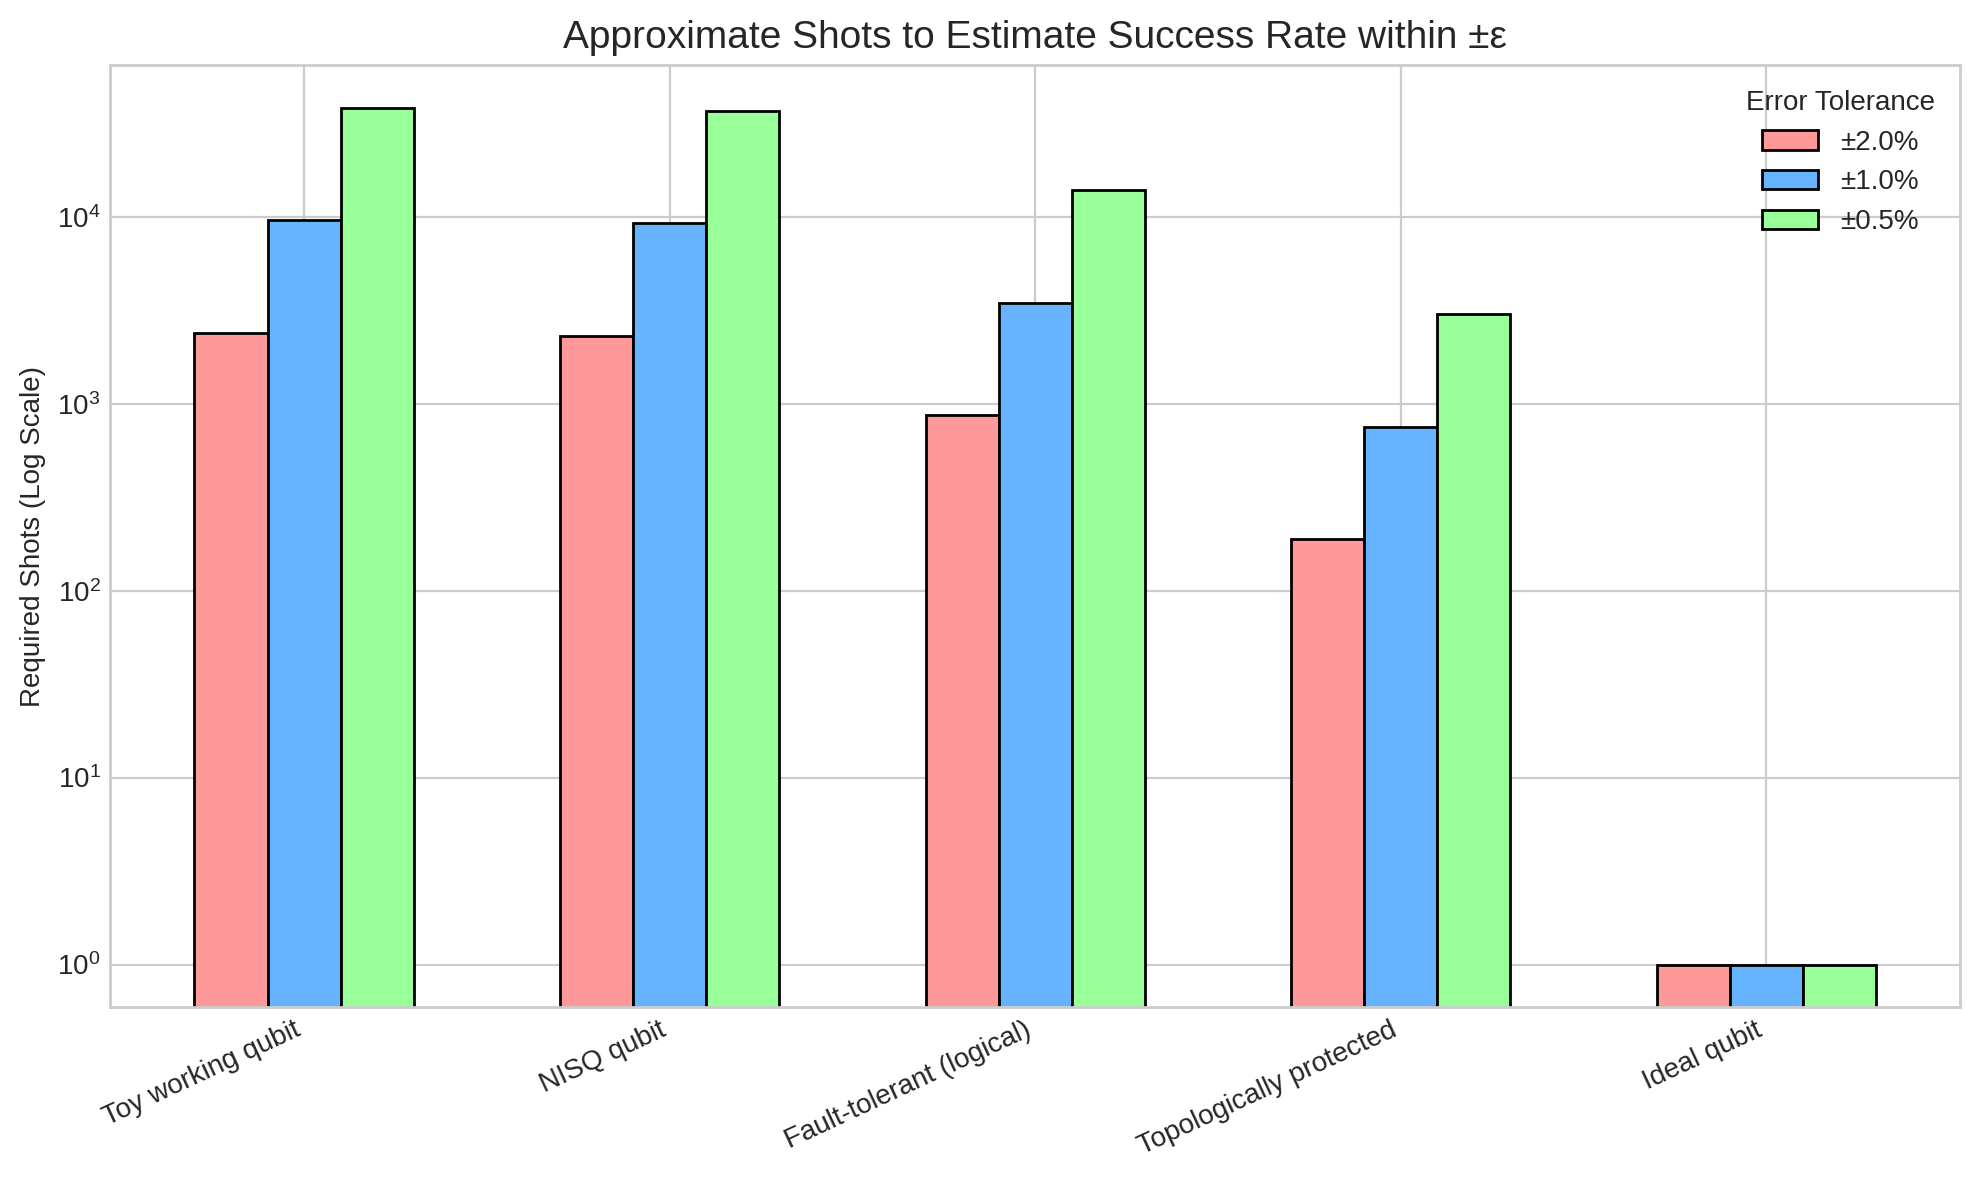

Generated and saved plots.


##  Qubit Sampling Budget - Summary

,Model,Description,Configured p (target),Shots,Ones (successes),Zeros (failures),Ones fraction (observed),Wilson CI 95% low,Wilson CI 95% high,CI width (95%),Required shots for ±2%,Required shots for ±1%,Required shots for ±0%,Illustrative cost (USD)
0,Toy working qubit,Simple demonstrator; about half shots meet the criterion.,0.50,10000,5046,4954,0.5046,0.4948,0.5144,0.0196,2401,9604,38416,$0.60
1,NISQ qubit,Noisy Intermediate-Scale Quantum device; modest success rate above chance.,0.60,10000,5935,4065,0.5935,0.5838,0.6031,0.0193,2305,9220,36880,$0.60
2,Fault-tolerant (logical),Error-corrected logical qubit; high single-shot success probability.,0.90,10000,9013,987,0.9013,0.8953,0.9070,0.0117,865,3458,13830,$0.60
3,Topologically protected,Intrinsic protection; very high single-shot success probability.,0.98,10000,9795,205,0.9795,0.9765,0.9821,0.0056,189,753,3012,$0.60
4,Ideal qubit,Theoretical perfect qubit; always successful in a single shot.,1.00,10000,10000,0,1.0000,0.9996,1.0000,0.0004,1,1,1,$0.60



SCRIPT COMPLETE
Google Colab notebook saved to: Sampling_Budget_Qubit_Bitstrings.ipynb
Summary data saved to: summary.csv
Plots saved to: fig_ones_fraction.png, fig_required_shots.png


In [11]:
# This script builds a small simulation toolkit, runs it with sensible defaults,
# generates tables and figures, so you can iterate further.
#
# Contents created in the current directory:
#  - Sampling_Budget_Qubit_Bitstrings.ipynb      (Colab notebook)
#  - summary.csv                                 (summary table)
#  - bitstrings_<MODEL>.csv                      (raw bit-strings per model)
#  - fig_ones_fraction.png                       (bar chart with Wilson CI)
#  - fig_required_shots.png                      (required shots for ±ε)
#  - simulation_config.json                      (run parameters)

import json
import math
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import nbformat as nbf

plt.rcParams['figure.dpi'] = 200

# ---------- Helper math ----------

def wilson_ci(k: int, n: int, z: float = 1.96) -> Tuple[float, float]:
    """
    Wilson score interval for binomial proportion with confidence ~95% at z=1.96.
    Returns (low, high). Works for edge cases k=0 or k=n.
    """
    if n == 0:
        return (0.0, 1.0)
    p_hat = k / n
    denom = 1.0 + (z ** 2) / n
    center = (p_hat + (z ** 2) / (2 * n)) / denom
    span = (z * math.sqrt((p_hat * (1 - p_hat) / n) + (z ** 2) / (4 * n ** 2))) / denom
    return (max(0.0, center - span), min(1.0, center + span))


def shots_for_epsilon(p: float, epsilon: float = 0.01, z: float = 1.96) -> int:
    """
    Approximate shots needed to estimate a Bernoulli mean p within ±epsilon (absolute error)
    at ~95% confidence using normal approximation. Clamps to at least 1 shot.
    """
    p = min(max(p, 0.0), 1.0)
    var = p * (1.0 - p)
    if var == 0.0:
        return 1
    n = (z ** 2) * var / (epsilon ** 2)
    return max(1, int(math.ceil(n)))


# ---------- Domain model ----------

@dataclass(frozen=True)
class QubitModel:
    name: str
    satisfaction_prob: float  # Probability a single shot meets the analytical criterion (bit = 1)
    description: str


DEFAULT_MODELS: List[QubitModel] = [
    QubitModel(
        "Toy working qubit",
        0.50,
        "Simple demonstrator; about half shots meet the criterion."
    ),
    QubitModel(
        "NISQ qubit",
        0.60,
        "Noisy Intermediate-Scale Quantum device; modest success rate above chance."
    ),
    QubitModel(
        "Fault-tolerant (logical)",
        0.90,
        "Error-corrected logical qubit; high single-shot success probability."
    ),
    QubitModel(
        "Topologically protected",
        0.98,
        "Intrinsic protection; very high single-shot success probability."
    ),
    QubitModel(
        "Ideal qubit",
        1.00,
        "Theoretical perfect qubit; always successful in a single shot."
    ),
]

# ---------- Simulation configuration ----------

CONFIG: Dict = {
    "random_seed": 123456,
    "shots_per_model": 10000,
    "epsilons": [0.02, 0.01, 0.005],  # ±2%, ±1%, ±0.5% targets
    "cost_model": {
        "default_cost_per_shot_usd": 0.00005,
        "fixed_overhead_usd": 0.10
    },
    "timing": {
        "time_per_shot_seconds": 2e-6
    }
}

rng = np.random.default_rng(CONFIG["random_seed"])


# ---------- Core simulation ----------

def simulate_bitstring(p: float, shots: int, rng_: np.random.Generator) -> np.ndarray:
    """
    Generate a 0/1 bitstring for given per-shot success probability p and shot count.
    """
    return rng_.binomial(1, p, size=shots).astype(int)


def summarize_model(model: QubitModel, bits: np.ndarray, epsilons: List[float]) -> Dict:
    """
    Calculate summary statistics for a given model and its simulated bitstring.
    """
    n = int(bits.size)
    ones = int(bits.sum())
    zeros = int(n - ones)
    frac = ones / n if n > 0 else float("nan")
    lo, hi = wilson_ci(ones, n)

    row = {
        "Model": model.name,
        "Description": model.description,
        "Configured p (target)": model.satisfaction_prob,
        "Shots": n,
        "Ones (successes)": ones,
        "Zeros (failures)": zeros,
        "Ones fraction (observed)": frac,
        "Wilson CI 95% low": lo,
        "Wilson CI 95% high": hi,
        "CI width (95%)": hi - lo,
    }
    for eps in epsilons:
        row[f"Required shots for ±{int(eps*100)}%"] = shots_for_epsilon(model.satisfaction_prob, eps)
    return row


def apply_costs(shots: int, cost_per_shot: float, fixed_overhead: float) -> float:
    """
    Calculate illustrative cost based on shots and cost model.
    """
    return fixed_overhead + shots * cost_per_shot


# ---------- Run the simulation ----------

all_bitstrings: Dict[str, np.ndarray] = {}
summary_rows: List[Dict] = []

print("Running simulation...")
for m in DEFAULT_MODELS:
    bits = simulate_bitstring(m.satisfaction_prob, CONFIG["shots_per_model"], rng)
    all_bitstrings[m.name] = bits
    summary_rows.append(summarize_model(m, bits, CONFIG["epsilons"]))

summary_df = pd.DataFrame(summary_rows)

# Add cost estimates
cps = CONFIG["cost_model"]["default_cost_per_shot_usd"]
over = CONFIG["cost_model"]["fixed_overhead_usd"]
if cps > 0 or over > 0:
    summary_df["Illustrative cost (USD)"] = [
        apply_costs(int(row["Shots"]), cps, over)
        for _, row in summary_df.iterrows()
    ]

# ---------- Save artifacts ----------

# Save raw bitstrings and summary CSV
for name, arr in all_bitstrings.items():
    out_path = f"bitstrings_{name.replace(' ', '_')}.csv"
    pd.DataFrame({"bit": arr}).to_csv(out_path, index=False)

summary_csv_path = "summary.csv"
summary_df.to_csv(summary_csv_path, index=False)

# Save config JSON
with open("simulation_config.json", "w") as f:
    json.dump(CONFIG, f, indent=2)

print("Saved data to CSV and JSON files.")

# ---------- Visualizations ----------

# Figure 1: Observed ones fraction with Wilson CI
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
x = np.arange(len(summary_df))
y = summary_df["Ones fraction (observed)"].to_numpy()

# --- FIX APPLIED HERE ---
# Take the absolute value to prevent tiny negative numbers from floating-point
# inaccuracies from causing a ValueError in the errorbar plot.
lower_error = y - summary_df["Wilson CI 95% low"].to_numpy()
upper_error = summary_df["Wilson CI 95% high"].to_numpy() - y
yerr = np.vstack([np.abs(lower_error), np.abs(upper_error)])
# --- END OF FIX ---

plt.bar(x, y, color='skyblue', edgecolor='black')
plt.errorbar(x, y, yerr=yerr, fmt="none", capsize=5, color="black", elinewidth=1.5)
plt.xticks(x, summary_df["Model"].tolist(), rotation=25, ha="right")
plt.ylabel("Observed Ones Fraction")
plt.title("Observed Single-Shot Success Rates with 95% Wilson CI", fontsize=14)
plt.tight_layout()
fig1_path = "fig_ones_fraction.png"
plt.savefig(fig1_path, dpi=200, bbox_inches='tight')
plt.show()

# Figure 2: Required shots at several ±epsilon targets
plt.figure(figsize=(10, 6))
width = 0.2
x = np.arange(len(DEFAULT_MODELS))
colors = ['#ff9999','#66b3ff','#99ff99']

for i, eps in enumerate(CONFIG["epsilons"]):
    req = [shots_for_epsilon(m.satisfaction_prob, eps) for m in DEFAULT_MODELS]
    plt.bar(x + i * width, req, width, label=f"±{eps:.1%}", color=colors[i], edgecolor='black')

plt.xticks(x + width, [m.name for m in DEFAULT_MODELS], rotation=25, ha="right")
plt.ylabel("Required Shots (Log Scale)")
plt.title("Approximate Shots to Estimate Success Rate within ±ε", fontsize=14)
plt.yscale('log')
plt.legend(title="Error Tolerance")
plt.tight_layout()
fig2_path = "fig_required_shots.png"
plt.savefig(fig2_path, dpi=200, bbox_inches='tight')
plt.show()

print("Generated and saved plots.")

# ---------- Display interactive table ----------

display(Markdown("##  Qubit Sampling Budget - Summary"))
display(summary_df.style.format({
    "Configured p (target)": "{:.2f}",
    "Ones fraction (observed)": "{:.4f}",
    "Wilson CI 95% low": "{:.4f}",
    "Wilson CI 95% high": "{:.4f}",
    "CI width (95%)": "{:.4f}",
    "Illustrative cost (USD)": "${:.2f}"
}))


# ---------- Build a ready-to-run Colab notebook ----------

md_intro = r"""
# Sampling Budget & Bit-String Analogy for Qubit Classes

**High school level (concise):** We treat each measurement (“single shot”) as a bit: `1` if the outcome matches the analytical prediction, `0` if it does not. Different qubit types have different chances of landing a `1`. We simulate many shots, show how often we get `1`s, and estimate how many shots we need for a target accuracy.

**Graduate level (concise):** We model single-shot “threshold of satisfaction” as a Bernoulli process with success probability $p$ per qubit class: toy, NISQ (noisy intermediate-scale quantum), fault-tolerant (logical), topologically protected, and ideal. We report Wilson score intervals (95%) for observed proportions and estimate the required shot budget $n \approx z^2\,p(1-p)/\epsilon^2$ to bound absolute error by ±$\epsilon$ at ~95% confidence.
"""

code_config = r"""
# @title Configuration
from dataclasses import dataclass
from typing import List, Dict
import numpy as np

RANDOM_SEED = 579345  # @param {type:"number"}
SHOTS_PER_MODEL = 10000  # @param {type:"number"}
EPSILONS = [0.02, 0.01, 0.005]  # @param
COST_PER_SHOT_USD = 0.00005  # @param {type:"number"}
FIXED_OVERHEAD_USD = 0.10    # @param {type:"number"}

@dataclass(frozen=True)
class QubitModel:
    name: str
    satisfaction_prob: float
    description: str

MODELS: List[QubitModel] = [
    QubitModel("Toy working qubit", 0.50, "Simple demonstrator"),
    QubitModel("NISQ qubit", 0.60, "Noisy Intermediate-Scale Quantum device"),
    QubitModel("Fault-tolerant (logical)", 0.90, "Error-corrected logical qubit"),
    QubitModel("Topologically protected", 0.98, "Intrinsic protection"),
    QubitModel("Ideal qubit", 1.00, "Theoretical perfect qubit"),
]

rng = np.random.default_rng(RANDOM_SEED)
"""

code_lib_and_run = r"""
# @title Run Simulation & Display Results
import math
from typing import Tuple, Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

def wilson_ci(k: int, n: int, z: float = 1.96) -> Tuple[float, float]:
    if n == 0: return (0.0, 1.0)
    p_hat, z2_n = k / n, z**2 / n
    denom = 1.0 + z2_n
    center = (p_hat + z2_n / 2) / denom
    span = (z * math.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2))) / denom
    return (max(0.0, center - span), min(1.0, center + span))

def shots_for_epsilon(p: float, epsilon: float = 0.01, z: float = 1.96) -> int:
    if p * (1-p) == 0: return 1
    return max(1, int(math.ceil((z**2 * p * (1-p)) / (epsilon**2))))

def summarize_model(model, bits: np.ndarray, epsilons) -> Dict:
    n = len(bits)
    ones = sum(bits)
    lo, hi = wilson_ci(ones, n)
    row = {
        "Model": model.name, "p (target)": model.satisfaction_prob, "Shots": n,
        "Ones": ones, "p (observed)": ones / n if n > 0 else 0,
        "CI 95% low": lo, "CI 95% high": hi, "CI width": hi - lo,
    }
    for eps in epsilons:
        row[f"Shots for ±{eps:.1%}"] = shots_for_epsilon(model.satisfaction_prob, eps)
    return row

# --- Run Simulation ---
summary_rows = [summarize_model(m, rng.binomial(1, m.satisfaction_prob, SHOTS_PER_MODEL), EPSILONS) for m in MODELS]
summary_df = pd.DataFrame(summary_rows)
if COST_PER_SHOT_USD > 0 or FIXED_OVERHEAD_USD > 0:
    summary_df["Cost (USD)"] = FIXED_OVERHEAD_USD + summary_df["Shots"] * COST_PER_SHOT_USD

display(Markdown("### Simulation Summary"))
display(summary_df.style.format(precision=4).background_gradient(cmap='viridis', subset=['p (observed)', 'CI width']))

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1
y = summary_df["p (observed)"].to_numpy()
lower_error = y - summary_df["CI 95% low"]
upper_error = summary_df["CI 95% high"] - y
yerr = np.vstack([np.abs(lower_error), np.abs(upper_error)])

ax1.bar(summary_df["Model"], y, yerr=yerr, capsize=5, color='skyblue', edgecolor='black', ecolor='black')
ax1.set_title("Observed Success Rate (95% Wilson CI)", fontsize=14)
ax1.tick_params(axis='x', rotation=30, labelsize=10)

# Plot 2
width = 0.2
x = np.arange(len(MODELS))
colors = ['#ff9999','#66b3ff','#99ff99']
for i, eps in enumerate(EPSILONS):
    req = summary_df[f"Shots for ±{eps:.1%}"]
    ax2.bar(x + i * width, req, width, label=f"±{eps:.1%}", color=colors[i], edgecolor='black')

ax2.set_xticks(x + width, summary_df["Model"])
ax2.set_ylabel("Required Shots (Log Scale)")
ax2.set_yscale('log')
ax2.set_title("Shots Needed for ±ε Tolerance", fontsize=14)
ax2.tick_params(axis='x', rotation=30, labelsize=10)
ax2.legend(title="Tolerance")

plt.tight_layout()
plt.show()
"""

nb = nbf.v4.new_notebook()
nb["cells"] = [
    nbf.v4.new_markdown_cell(md_intro),
    nbf.v4.new_code_cell(code_config),
    nbf.v4.new_code_cell(code_lib_and_run),
]

nb_path = "Sampling_Budget_Qubit_Bitstrings.ipynb"
with open(nb_path, "w", encoding="utf-8") as f:
    nbf.write(nb, f)

# ---------- Final confirmation ----------
print("\n" + "="*50)
print("SCRIPT COMPLETE")
print("="*50)
print(f"Google Colab notebook saved to: {nb_path}")
print(f"Summary data saved to: {summary_csv_path}")
print(f"Plots saved to: {fig1_path}, {fig2_path}")

-----

## References

1.  Agresti, A. and Coull, B.A. (1998) 'Approximate is better than “exact” for interval estimation of binomial proportions', *The American Statistician*, 52(2), pp. 119-126.
2.  Brown, L.D., Cai, T.T. and DasGupta, A. (2001) 'Interval Estimation for a Binomial Proportion', *Statistical Science*, 16(2), pp. 101-133.
3.  Cochran, W.G. (1977) *Sampling Techniques*. 3rd edn. New York: John Wiley & Sons.
4.  Gottesman, D. (2009) 'An introduction to quantum error correction and fault-tolerant quantum computation', in *Quantum Information Science and Its Contributions to Mathematics, Proceedings of Symposia in Applied Mathematics*, 72, pp. 13-58.
5.  Harris, C.R., Millman, K.J., van der Walt, S.J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N.J., Kern, R., Picus, M., Hoyer, S., van Kerkwijk, M.H., Brett, M., Haldane, A., del Río, J.F., Wiebe, M., Peterson, P., Gérard-Marchant, P., Sheppard, K., Reddy, T., Weckesser, W., Abbasi, H., Gohlke, C. and Oliphant, T.E. (2020) 'Array programming with NumPy', *Nature*, 585, pp. 357–362.
6.  Hunter, J.D. (2007) 'Matplotlib: A 2D Graphics Environment', *Computing in Science & Engineering*, 9(3), pp. 90-95.
7.  Kitaev, A.Y. (2003) 'Fault-tolerant quantum computation by anyons', *Annals of Physics*, 303(1), pp. 2-30.
8.  McKinney, W. (2010) 'Data Structures for Statistical Computing in Python', in *Proceedings of the 9th Python in Science Conference*, pp. 56-61.
9.  Nayak, C., Simon, S.H., Stern, A., Freedman, M. and Das Sarma, S. (2008) 'Non-Abelian anyons and topological quantum computation', *Reviews of Modern Physics*, 80(3), pp. 1083-1159.
10. Newman, M. (2013) *Computational Physics*. CreateSpace Independent Publishing Platform.
11. Nielsen, M.A. and Chuang, I.L. (2010) *Quantum Computation and Quantum Information: 10th Anniversary Edition*. Cambridge: Cambridge University Press.
12. Preskill, J. (2018) 'Quantum Computing in the NISQ era and beyond', *Quantum*, 2, p. 79.
13. The pandas development team (2020) *pandas-dev/pandas: Pandas*. Zenodo. Available at: [https://doi.org/10.5281/zenodo.3509134](https://www.google.com/search?q=https://doi.org/10.5281/zenodo.3509134).
14. Virtanen, P., Gommers, R., Oliphant, T.E., Haberland, M., Reddy, T., Cournapeau, D., Burovski, E., Peterson, P., Weckesser, W., Bright, J., van der Walt, S.J., Brett, M., Wilson, J., Millman, K.J., Mayorov, N., Nelson, A.R.J., Jones, E., Kern, R., Larson, E., Carey, C.J., Polat, İ., Feng, Y., Moore, E.W., VanderPlas, J., Laxalde, D., Perktold, J., Cimrman, R., Henriksen, I., Quintero, E.A., Harris, C.R., Archibald, A.M., Ribeiro, A.H., Pedregosa, F., van Mulbregt, P. and SciPy 1.0 Contributors (2020) 'SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python', *Nature Methods*, 17, pp. 261–272.
15. Wilde, M.M. (2017) *Quantum Information Theory*. 2nd edn. Cambridge: Cambridge University Press.
16. Wilson, E.B. (1927) 'Probable inference, the law of succession, and statistical inference', *Journal of the American Statistical Association*, 22(158), pp. 209-212.
